In [1]:
## Task:

# Look at https://github.com/sundeepblue/movie_rating_prediction and download data file movie_metadata.csv.

# Then

 

#     Get additional data from other sources if required.
#     Perform Data Preprocessing and Exploratory Data Analysis which includes data visualization also.
#     Create at least 3 different machine learning models to predict IMDB rating of a movie.
#     Compare the results and suggest the model which could be useful to deploy into production.
#     Optional: you can also use TensorFlow, Keras or Pytorch to build the models.  

 

# Send your work (code and results and process documentation) as Python notebook output (.html or .ipynb files).

In [2]:
import warnings
import requests 
import json
from dask import delayed, compute
import dask
from xml.etree import ElementTree
from matplotlib import pyplot as plt
# %matplotlib notebook

from scipy.stats import zscore
import collections
plt.rcParams['figure.figsize']=(12,8)

from dask.diagnostics import ProgressBar
ProgressBar().register()

warnings.filterwarnings('ignore')

#Simpled desiged function to give a birds eye look into the dataset.

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sb

from sklearn import model_selection
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score,r2_score,classification_report, roc_auc_score
from sklearn.preprocessing import LabelEncoder,OneHotEncoder, StandardScaler, Normalizer
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold,StratifiedKFold, cross_val_score
from sklearn.ensemble import BaggingClassifier,RandomForestClassifier,AdaBoostClassifier,ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

def read_basic(name=None):
    if(name==None):
        raise ValueError('No File Name provided')
        return 0
    print('-------------------{}----------------'.format(name))
    df = pd.read_csv(name)
    print('Datatypes: \n', df.dtypes)
    print('-----------------------------\n')
    print('Dimension: \n', df.shape)
    print('-----------------------------\n')
    print('Missing values per column (Percentage): \n', (df.isna().sum()/df.shape[0])*100)
    print('-----------------------------\n')
    print('Dataframe Info: \n', df.info())
    print('-----------------------------\n')
    print('Descriptive Stats: \n', df.describe())

    return df# %load mlpack.py

c:\python36\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


In [3]:
imdb_db = read_basic('movie_metadata.csv')

-------------------movie_metadata.csv----------------
Datatypes: 
 color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_sco

In [4]:
imdb_db.head()

color      director_name  num_critic_for_reviews  duration  \
0  Color      James Cameron                   723.0     178.0   
1  Color     Gore Verbinski                   302.0     169.0   
2  Color         Sam Mendes                   602.0     148.0   
3  Color  Christopher Nolan                   813.0     164.0   
4    NaN        Doug Walker                     NaN       NaN   

   director_facebook_likes  actor_3_facebook_likes      actor_2_name  \
0                      0.0                   855.0  Joel David Moore   
1                    563.0                  1000.0     Orlando Bloom   
2                      0.0                   161.0      Rory Kinnear   
3                  22000.0                 23000.0    Christian Bale   
4                    131.0                     NaN        Rob Walker   

   actor_1_facebook_likes        gross                           genres  \
0                  1000.0  760505847.0  Action|Adventure|Fantasy|Sci-Fi   
1                 40000.0  309404152.0         Action|Adventure|Fantasy   
2                 11000.0  200074175.0        Action|Adventure|Thriller   
3                 27000.0  448130642.0                  Action|Thriller   
4                   131.0          NaN                      Documentary   

          ...          num_user_for_reviews language  country  content_rating  \
0         ...                        3054.0  English      USA           PG-13   
1         ...                        1238.0  English      USA           PG-13   
2         ...                         994.0  English       UK           PG-13   
3         ...                        2701.0  English      USA           PG-13   
4         ...                           NaN      NaN      NaN             NaN   

        budget  title_year actor_2_facebook_likes imdb_score  aspect_ratio  \
0  237000000.0      2009.0                  936.0        7.9          1.78   
1  300000000.0      2007.0                 5000.0        7.1          2.35   
2  245000000.0      2015.0                  393.0        6.8          2.35   
3  250000000.0      2012.0                23000.0        8.5          2.35   
4          NaN         NaN                   12.0        7.1           NaN   

  movie_facebook_likes  
0                33000  
1                    0  
2                85000  
3               164000  
4                    0  

[5 rows x 28 columns]

In [5]:
#Lets check if the data types are in order 
print(imdb_db.dtypes)
# imdb_db.columns

color                         object
director_name                 object
num_critic_for_reviews       float64
duration                     float64
director_facebook_likes      float64
actor_3_facebook_likes       float64
actor_2_name                  object
actor_1_facebook_likes       float64
gross                        float64
genres                        object
actor_1_name                  object
movie_title                   object
num_voted_users                int64
cast_total_facebook_likes      int64
actor_3_name                  object
facenumber_in_poster         float64
plot_keywords                 object
movie_imdb_link               object
num_user_for_reviews         float64
language                      object
country                       object
content_rating                object
budget                       float64
title_year                   float64
actor_2_facebook_likes       float64
imdb_score                   float64
aspect_ratio                 float64
m

In [6]:
# #Documents that do not have title_year are probably mis-reported and currently there are 2 percent of the data with
#such problems, so we can safely drop them
missing = imdb_db.title_year.dropna().index.tolist()
imdb_db = imdb_db.loc[missing,:]

In [7]:
imdb_db.reset_index()
imdb_db.info()
#MIssing values (Percentage wise):

# Missing values per column (Percentage): 
# color                         0.376760
# director_name                 2.062265
# num_critic_for_reviews        0.991473
# duration                      0.297442
# director_facebook_likes       2.062265
# actor_3_facebook_likes        0.456078
# actor_2_name                  0.257783
# actor_1_facebook_likes        0.138806
# gross                        17.529248
# genres                        0.000000
# actor_1_name                  0.138806
# movie_title                   0.000000
# num_voted_users               0.000000
# cast_total_facebook_likes     0.000000
# actor_3_name                  0.456078
# facenumber_in_poster          0.257783
# plot_keywords                 3.033908
# movie_imdb_link               0.000000
# num_user_for_reviews          0.416419
# language                      0.237954
# country                       0.099147
# content_rating                6.008328
# budget                        9.756098
# title_year                    2.141582
# actor_2_facebook_likes        0.257783
# imdb_score                    0.000000
# aspect_ratio                  6.523895
# movie_facebook_likes          0.000000

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4935 entries, 0 to 5042
Data columns (total 28 columns):
color                        4920 non-null object
director_name                4935 non-null object
num_critic_for_reviews       4894 non-null float64
duration                     4923 non-null float64
director_facebook_likes      4935 non-null float64
actor_3_facebook_likes       4917 non-null float64
actor_2_name                 4925 non-null object
actor_1_facebook_likes       4928 non-null float64
gross                        4156 non-null float64
genres                       4935 non-null object
actor_1_name                 4928 non-null object
movie_title                  4935 non-null object
num_voted_users              4935 non-null int64
cast_total_facebook_likes    4935 non-null int64
actor_3_name                 4917 non-null object
facenumber_in_poster         4922 non-null float64
plot_keywords                4795 non-null object
movie_imdb_link              4935 non-

In [8]:
imdb_db.color = imdb_db.color.astype('category')
imdb_db.title_year = imdb_db.title_year.astype(np.int)


In [9]:
# The most number of missing values are in gross column: about ~ 17 percent, which we cannot straight away drop, 
# as we risk losing lot of data. Gross is a float object. Let us see how it fares.

imdb_db.gross.agg([np.mean, np.median, np.min, np.max])

mean      4.850314e+07
median    2.552969e+07
amin      1.620000e+02
amax      7.605058e+08
Name: gross, dtype: float64

In [10]:
print(imdb_db.corr()['gross'])
#We see that gross has a maximum correlation with num_voted_users of about 0.64/
#Lets create a simple Linear regression model between (num_voted_users, gross) to impute missing values
imdb_num_users_gross = imdb_db[~imdb_db.num_voted_users.isna()]
imdb_num_users_gross = imdb_db[~imdb_db.gross.isna()]
# imdb_num_users_gross.gross.isna().sum()

num_critic_for_reviews       0.480420
duration                     0.254586
director_facebook_likes      0.144945
actor_3_facebook_likes       0.307898
actor_1_facebook_likes       0.154270
gross                        1.000000
num_voted_users              0.637167
cast_total_facebook_likes    0.247184
facenumber_in_poster        -0.028106
num_user_for_reviews         0.559804
budget                       0.102179
title_year                   0.030886
actor_2_facebook_likes       0.262614
imdb_score                   0.199432
aspect_ratio                 0.068788
movie_facebook_likes         0.377961
Name: gross, dtype: float64


In [11]:
model = LinearRegression()
model.fit(imdb_num_users_gross[['num_voted_users']], imdb_num_users_gross[['gross']])
# imdb_db.plot(x='num_voted_users', y='gross', kind='scatter')

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [12]:
from sklearn.metrics import r2_score
r2_score(imdb_num_users_gross[['gross']], model.predict(imdb_num_users_gross[['num_voted_users']]))
#This model has an acceptable R2 score. We use it to impute gross value.

0.4059816164887172

In [13]:
gross_vals = pd.Series(model.predict(imdb_db[['num_voted_users']]).ravel())
imdb_db.gross = imdb_db.gross.combine_first(gross_vals)

In [14]:
print('Missing values per column (Percentage): \n', (imdb_db.isna().sum()/imdb_db.shape[0])*100)

Missing values per column (Percentage): 
 color                        0.303951
director_name                0.000000
num_critic_for_reviews       0.830800
duration                     0.243161
director_facebook_likes      0.000000
actor_3_facebook_likes       0.364742
actor_2_name                 0.202634
actor_1_facebook_likes       0.141844
gross                        1.256332
genres                       0.000000
actor_1_name                 0.141844
movie_title                  0.000000
num_voted_users              0.000000
cast_total_facebook_likes    0.000000
actor_3_name                 0.364742
facenumber_in_poster         0.263425
plot_keywords                2.836879
movie_imdb_link              0.000000
num_user_for_reviews         0.303951
language                     0.182371
country                      0.020263
content_rating               5.288754
budget                       7.943262
title_year                   0.000000
actor_2_facebook_likes       0.202634
imdb_sco

In [15]:
#For budget, lets impute the missing values with the median
imdb_db.budget = imdb_db.budget.fillna(imdb_db.budget.median())

#For aspect_ratio, lets impute the missing values with the mode, as value_counts show 
#the distribution is maximum for mode value = 2.35

imdb_db.aspect_ratio = imdb_db.aspect_ratio.fillna(imdb_db.aspect_ratio.mode())

In [16]:
print('Missing values per column (Percentage): \n', (imdb_db.isna().sum()/imdb_db.shape[0])*100)
#LLets target content_rating which has 5 percent missing values

Missing values per column (Percentage): 
 color                        0.303951
director_name                0.000000
num_critic_for_reviews       0.830800
duration                     0.243161
director_facebook_likes      0.000000
actor_3_facebook_likes       0.364742
actor_2_name                 0.202634
actor_1_facebook_likes       0.141844
gross                        1.256332
genres                       0.000000
actor_1_name                 0.141844
movie_title                  0.000000
num_voted_users              0.000000
cast_total_facebook_likes    0.000000
actor_3_name                 0.364742
facenumber_in_poster         0.263425
plot_keywords                2.836879
movie_imdb_link              0.000000
num_user_for_reviews         0.303951
language                     0.182371
country                      0.020263
content_rating               5.288754
budget                       0.000000
title_year                   0.000000
actor_2_facebook_likes       0.202634
imdb_sco

In [17]:
#We have below cross tab data based on genres vs content_rating
crosstab_genres_rating = pd.crosstab(imdb_db.genres.apply(lambda x: x.split('|')[0]), imdb_db.content_rating)
crosstab_genres_rating

content_rating  Approved   G  GP  M  NC-17  Not Rated   PG  PG-13  Passed  \
genres                                                                      
Action                 9   9   1  1      0         10  140    462       0   
Adventure              9  57   0  0      0          5  205     82       2   
Animation              3  11   0  0      0          0   32      3       0   
Biography              3   3   1  1      1          1   39     80       2   
Comedy                10  14   1  0      2         21  161    431       1   
Crime                  3   0   2  0      1         18    0     35       0   
Documentary            0   7   0  0      0          8   16     11       0   
Drama                 14   8   1  1      2         38   89    293       3   
Family                 0   2   0  0      0          0    6      0       0   
Fantasy                0   0   0  0      1          3    4     12       0   
Film-Noir              0   0   0  0      0          0    0      0       0   
Horror                 1   0   0  1      0          6    4     35       0   
Music                  0   0   0  0      0          0    0      0       0   
Musical                1   0   0  0      0          0    1      1       1   
Mystery                0   0   0  0      0          1    0      9       0   
Romance                0   0   0  0      0          0    0      2       0   
Sci-Fi                 0   1   0  0      0          0    2      3       0   
Thriller               1   0   0  0      0          4    1      0       0   
Western                1   0   0  1      0          0    1      2       0   

content_rating    R  TV-14  TV-G  TV-PG  Unrated  X  
genres                                               
Action          459      1     0      0        3  1  
Adventure        73      0     0      0        2  0  
Animation         6      0     1      0        0  0  
Biography       108      0     0      0        3  0  
Comedy          562      1     3      1       14  5  
Crime           257      0     0      1        2  0  
Documentary       6      0     0      0        5  0  
Drama           419      0     0      1       22  1  
Family            0      0     0      0        0  0  
Fantasy          27      0     0      0        3  1  
Film-Noir         0      0     0      0        1  0  
Horror          161      1     0      0        4  4  
Music             1      0     0      0        0  0  
Musical           0      0     0      0        0  0  
Mystery          20      0     0      0        0  1  
Romance           0      0     0      0        0  0  
Sci-Fi            4      0     0      0        1  0  
Thriller         10      0     0      0        1  0  
Western           5      0     0      0        1  0

In [18]:
imdb_db.content_rating.value_counts().plot(kind='bar')

Index(['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime',
       'Documentary', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'Horror',
       'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller',
       'Western'],
      dtype='object', name='genres') Index(['Approved', 'G', 'GP', 'M', 'NC-17', 'Not Rated', 'PG', 'PG-13',
       'Passed', 'R', 'TV-14', 'TV-G', 'TV-PG', 'Unrated', 'X'],
      dtype='object', name='content_rating')


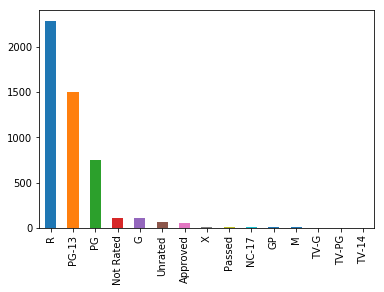

In [19]:
print(crosstab_genres_rating.index, crosstab_genres_rating.columns)
# 'Approved', 'G', 'GP', 'M', 'NC-17', 'Not Rated', 'PG', 'PG-13',
#        'Passed', 'R', 'TV-14', 'TV-G', 'TV-PG', 'Unrated', 'X'
dict_ = {'Action': 'PG-13', 'Adventure': 'PG', 'Animation': 'PG', 'Biography': 'R', 'Comedy': 'R', 'Crime': 'R',
       'Documentary': 'PG', 'Drama':'R', 'Family': 'PG', 'Fantasy':'R', 'Film-Noir':'Unrated', 'Horror':'R',
       'Music':'R', 'Musical':'PG', 'Mystery':'R', 'Romance':'PG-13', 'Sci-Fi':'R', 'Thriller':'R',
       'Western': 'R'}
new_content_rating = pd.Series(imdb_db.genres.apply(lambda x: dict_[x.split('|')[0]] if x.split('|')[0] in dict_.keys() else 'Unrated'))
imdb_db.content_rating = imdb_db.content_rating.combine_first(new_content_rating)
imdb_db.content_rating.value_counts().plot(kind='bar')

In [20]:
print('Missing values per column (Percentage): \n', (imdb_db.isna().sum()/imdb_db.shape[0])*100)

Missing values per column (Percentage): 
 color                        0.303951
director_name                0.000000
num_critic_for_reviews       0.830800
duration                     0.243161
director_facebook_likes      0.000000
actor_3_facebook_likes       0.364742
actor_2_name                 0.202634
actor_1_facebook_likes       0.141844
gross                        1.256332
genres                       0.000000
actor_1_name                 0.141844
movie_title                  0.000000
num_voted_users              0.000000
cast_total_facebook_likes    0.000000
actor_3_name                 0.364742
facenumber_in_poster         0.263425
plot_keywords                2.836879
movie_imdb_link              0.000000
num_user_for_reviews         0.303951
language                     0.182371
country                      0.020263
content_rating               0.000000
budget                       0.000000
title_year                   0.000000
actor_2_facebook_likes       0.202634
imdb_sco

In [21]:
#Now majority of the missing values are imputed, lets proceed with clearing the dataframe from NA values
imdb_db.dropna(inplace=True)
# imdb_db.drop('index', axis=1, inplace=True)
print(imdb_db.shape) #Original Dimension: (5043, 28) #New Dimesion (4729, 28)

#We have dropped (314) rows which is about 6 percent of the original data, which is acceptable.

(4495, 28)


In [22]:
#We are without any missing values now and ready to proceed with EDA
print('Missing values per column (Percentage): \n', (imdb_db.isna().sum()/imdb_db.shape[0])*100)

Missing values per column (Percentage): 
 color                        0.0
director_name                0.0
num_critic_for_reviews       0.0
duration                     0.0
director_facebook_likes      0.0
actor_3_facebook_likes       0.0
actor_2_name                 0.0
actor_1_facebook_likes       0.0
gross                        0.0
genres                       0.0
actor_1_name                 0.0
movie_title                  0.0
num_voted_users              0.0
cast_total_facebook_likes    0.0
actor_3_name                 0.0
facenumber_in_poster         0.0
plot_keywords                0.0
movie_imdb_link              0.0
num_user_for_reviews         0.0
language                     0.0
country                      0.0
content_rating               0.0
budget                       0.0
title_year                   0.0
actor_2_facebook_likes       0.0
imdb_score                   0.0
aspect_ratio                 0.0
movie_facebook_likes         0.0
dtype: float64


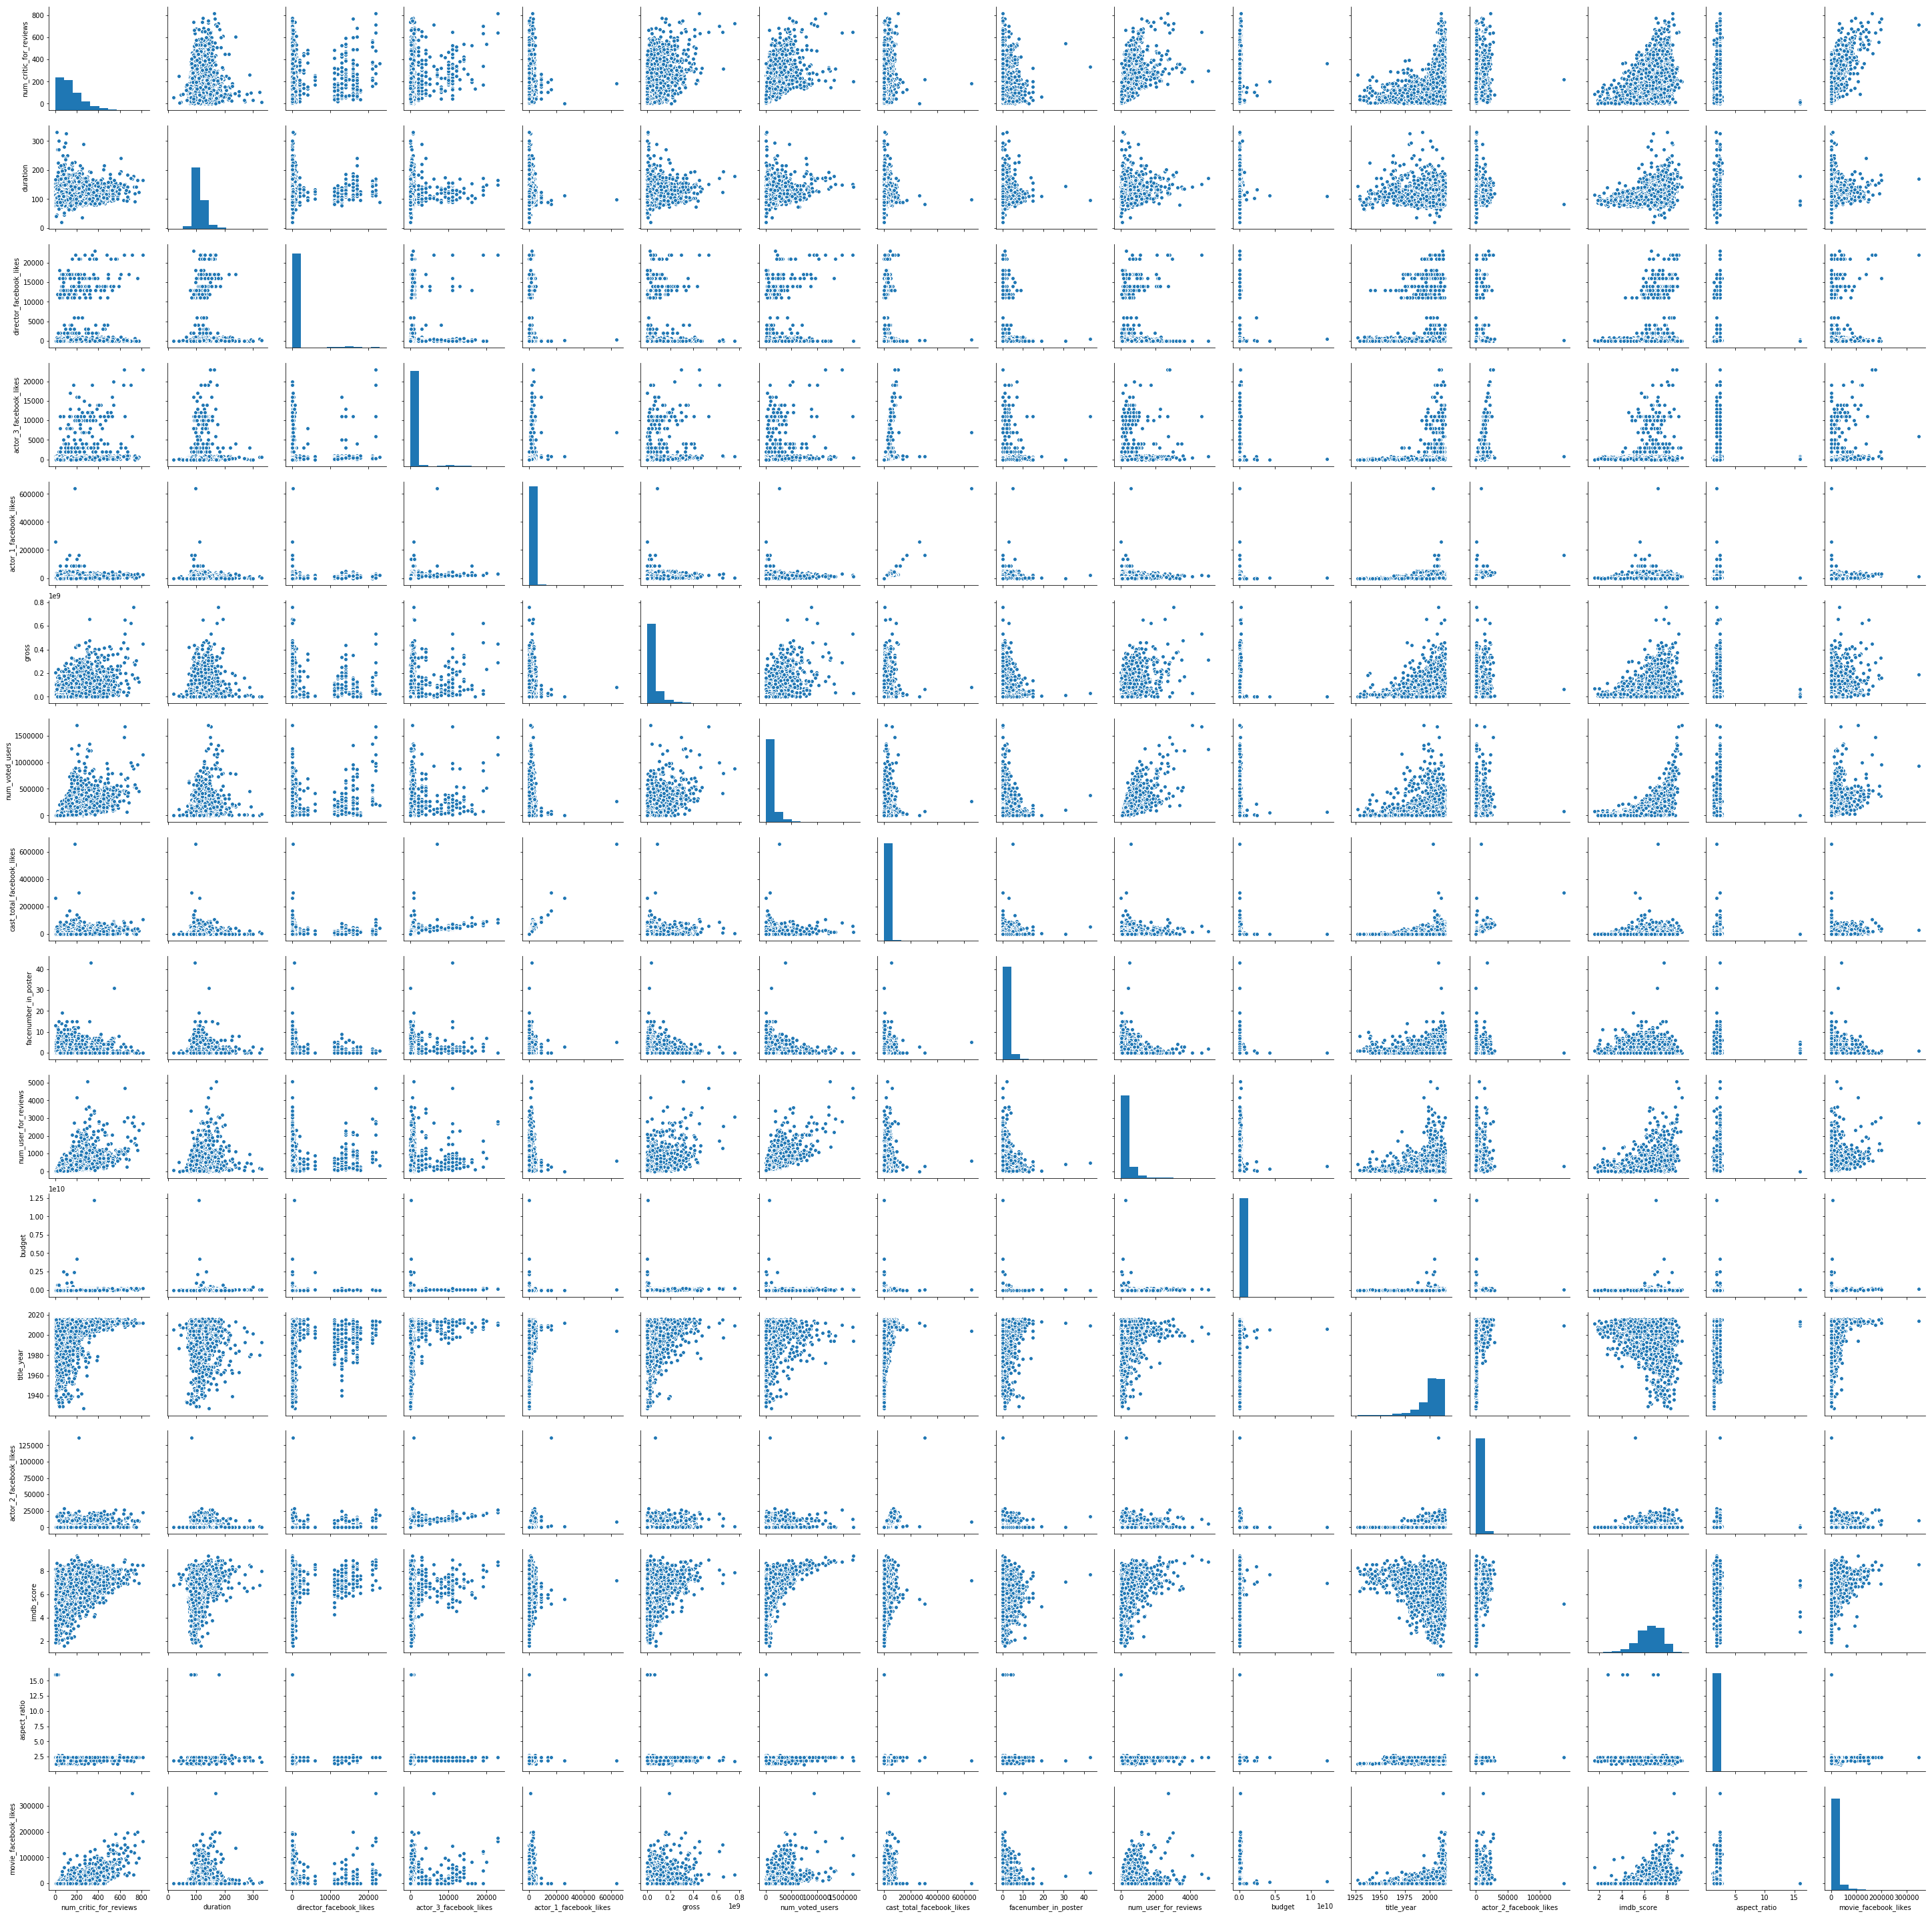

In [23]:
import seaborn as sb
sb.pairplot(imdb_db)

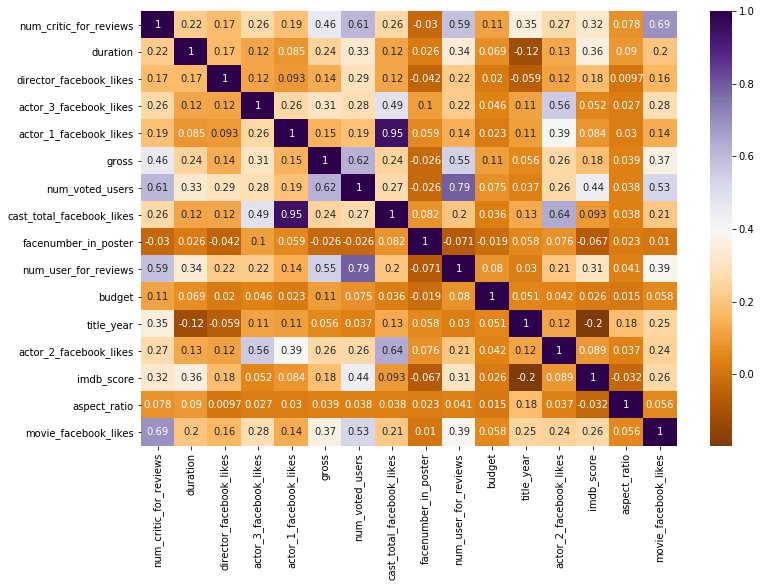

In [24]:
plt.figure(figsize=(12,8))
# plt.colormaps
sb.heatmap(imdb_db.corr(),annot=True,cmap = 'PuOr')

In [25]:
# imdb_db[['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes']]

filtered = imdb_db[['actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes']]
imdb_db['calc_likes'] = filtered.apply(np.sum,axis=1)
'''
We create a new feature calc_likes which is calculated total of all three actor likes in the database.
As observed in the heatmap below, actor_1_facebook_likes greatly correlates with calc_likes and also the already
provided feature cast_total_facebook_likes.
Therefore, we consider actor_1_facebook_likes to be enough estimator for the target withoutt the need for other 
features: actor_2_facebook_likes, actor_3_facebook_likes, cast_total_facebook_likes. Lets proceed to dropping them.
'''

imdb_db.drop(['actor_2_facebook_likes','actor_3_facebook_likes','cast_total_facebook_likes', 'calc_likes'], axis=1, inplace=True)

In [26]:
sb.heatmap(imdb_db.corr(),annot=True,cmap = 'PuOr')

In [27]:
#Lets drop num_voted_users from analysis since it is correlated to another continuous feature num_user_for_reviews

In [28]:
imdb_db.drop(['num_voted_users'], axis=1, inplace=True)

In [29]:
group_content_rating = imdb_db.groupby('content_rating')['imdb_score'].agg([np.mean, np.sum, np.median])
# group_content_rating.columns
group_content_rating.sort_values(by=['sum','median'], ascending=False)

mean      sum  median
content_rating                           
R               6.574771  13629.5     6.7
PG-13           6.276901   8913.2     6.4
PG              6.348661   4266.3     6.5
G               6.530476    685.7     6.7
Not Rated       6.826506    566.6     7.0
Approved        7.390566    391.7     7.4
Unrated         6.953333    312.9     6.9
X               6.500000     84.5     6.9
Passed          7.166667     64.5     7.1
NC-17           6.542857     45.8     6.8
GP              6.940000     34.7     6.7
M               6.840000     34.2     6.8
TV-14           4.766667     14.3     4.9
TV-G            5.000000     10.0     5.0

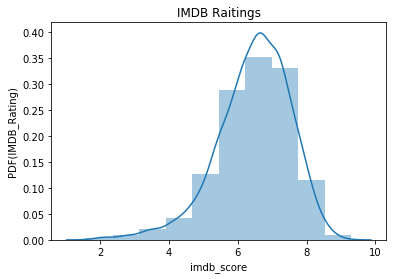

In [30]:
#Rating should not be sensitive to the nearest decimal, infact there will be very few movies with a 0

plt.title('IMDB Raitings')
plt.xlabel('Rating (0-10)')
plt.ylabel('PDF(IMDB_Rating)')
sb.distplot(imdb_db.imdb_score, bins=10)

# imdb_db.imdb_score[:10]

# imdb_db.plot('imdb_score', kind='hist')

#Based on the below histogram, it would be wiser to consider this as a classification problems instead of a regression problem.
#We can create 4 classes:
# '''
# Class 0: IMDB Rating 0-4
# Class 1: IMDB Rating 3-5
# Class 2: IMDB Rating 5-8
# Class 3: IMDB Rating 8-10

# '''
#We can create a new predictor to map imdb_rating in the dataset to these customized classes



In [31]:
#Good R2 score
# def convert_to_class(rating):
#     if(rating<=3):
#         return '1.5'
#     if(rating>3 and rating<=4):
#         return '3.5'
#     if(rating>4 and rating<=5):
#         return '4.5'
#     if(rating>5 and rating<=6):
#         return '5.5'
#     if(rating>6 and rating<=7):
#         return '6.5'
#     if(rating>7 and rating<=8):
#         return '7.5'
#     if(rating>8 and rating<=9):
#         return '8.5'
#     if(rating>9):
#         return '9.5'
#     return '-99'

In [32]:
def convert_to_class(rating):
    if(rating<=3):
        return '1.5'
    if(rating>3 and rating<=4):
        return '3.5'
    if(rating>4 and rating<=5):
        return '4.5'
    if(rating>5 and rating<=6):
        return '5.5'
    if(rating>6 and rating<=7):
        return '6.5'
    if(rating>7 and rating<=8):
        return '7.5'
    if(rating>8 and rating<=9):
        return '8.5'
    if(rating>9):
        return '9.5'
    return '-99'

In [33]:
imdb_db['class_rating'] = imdb_db.imdb_score.apply(convert_to_class)
imdb_scores = imdb_db['imdb_score']
# imdb_db.drop('imdb_score', axis=1, inplace=True)

6.5    1715
7.5    1205
5.5     967
4.5     280
8.5     198
3.5      91
1.5      37
9.5       2
Name: class_rating, dtype: int64

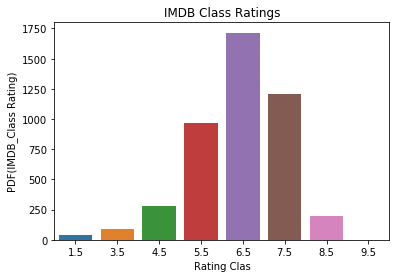

In [34]:
plt.title('IMDB Class Ratings')
plt.xlabel('Rating Clas')
plt.ylabel('PDF(IMDB_Class Rating)')
plt_params_x = imdb_db.class_rating.value_counts().index
plt_params_y = imdb_db.class_rating.value_counts().values
sb.barplot(plt_params_x, plt_params_y)
imdb_db.class_rating.value_counts()

In [35]:
# sb.barplot(imdb_db.class_rating.values, hue='color', data=imdb_db)

In [36]:
import researchpy as rp
from scipy import stats
table, results, expected = rp.crosstab(imdb_db['color'], imdb_db['class_rating'], test= 'chi-square', expected_freqs=True)  
table , results
#Just to verify with Chi-square test of independance if the categorical values 'color' and 'black and white' are independance.
#p-value of <=0.05 indicates, there is indeed independance. So we keep the attribute 'color' and move ahead

(                 class_rating                                         
                           1.5 3.5  4.5  5.5   6.5   7.5  8.5 9.5   All
 color                                                                 
 Color                      37  91  278  954  1657  1122  165   2  4306
  Black and White            0   0    2   13    58    83   33   0   189
 All                        37  91  280  967  1715  1205  198   2  4495,
                 Chi-square test   results
 0  Pearson Chi-square ( 7.0) =   134.5808
 1                    p-value =     0.0000
 2                 Cramer's V =     0.1730)

In [37]:
imdb_db.columns

Index(['color', 'director_name', 'num_critic_for_reviews', 'duration',
       'director_facebook_likes', 'actor_2_name', 'actor_1_facebook_likes',
       'gross', 'genres', 'actor_1_name', 'movie_title', 'actor_3_name',
       'facenumber_in_poster', 'plot_keywords', 'movie_imdb_link',
       'num_user_for_reviews', 'language', 'country', 'content_rating',
       'budget', 'title_year', 'imdb_score', 'aspect_ratio',
       'movie_facebook_likes', 'class_rating'],
      dtype='object')

In [38]:
# import researchpy as rp
# from scipy import stats
# table, results, expected = rp.crosstab(imdb_db['aspect_ratio'], imdb_db['class_rating'], test= 'chi-square', expected_freqs=True)  
# table , results

In [39]:
#Nomical festures can be dropped like movie_title, #Similarly movie imdb link
imdb_db.drop('movie_title', axis=1, inplace=True)
imdb_db.drop('movie_imdb_link', axis=1, inplace=True)

In [40]:
imdb_db.aspect_ratio = imdb_db.aspect_ratio.astype('category')

In [41]:
imdb_db.aspect_ratio.value_counts()
# If we look at the theory, then indeed 2.35 and 1.85 are most normal aspect ratios.
# VIDEO STANDARDS
# Eventually cinema converged on two leading standards: a normal 1.85:1 widescreen and an anamorphic 2.39:1 widescreen. With television, the formats became 4:3 with standard definition and later 16:9 with high definition, which at 1.78:1 
# was a close match to 1.85:1 widescreen cinema. 

#Based on this anything which is not 2.35 or 1.85, can be termed as rare, 
#and then we can enforce one-hot encoding convertion on aspect_ratio

imdb_db.aspect_ratio = imdb_db.aspect_ratio.apply(lambda x: 'rare' if not x in [2.35,1.85] else x)
imdb_db.aspect_ratio.value_counts()

2.35    2304
1.85    1876
rare     315
Name: aspect_ratio, dtype: int64

In [42]:
from sklearn.preprocessing import OneHotEncoder
ohot = OneHotEncoder()
# ohot.fit_transform(imdb_db.aspect_ratio.values)

aspect_dummies = pd.get_dummies(imdb_db.aspect_ratio, prefix='aspect', drop_first=False)
imdb_db = pd.concat([imdb_db, aspect_dummies], axis=1)
imdb_db.drop('aspect_ratio', axis=1, inplace=True)

In [43]:
imdb_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4495 entries, 0 to 5042
Data columns (total 25 columns):
color                      4495 non-null category
director_name              4495 non-null object
num_critic_for_reviews     4495 non-null float64
duration                   4495 non-null float64
director_facebook_likes    4495 non-null float64
actor_2_name               4495 non-null object
actor_1_facebook_likes     4495 non-null float64
gross                      4495 non-null float64
genres                     4495 non-null object
actor_1_name               4495 non-null object
actor_3_name               4495 non-null object
facenumber_in_poster       4495 non-null float64
plot_keywords              4495 non-null object
num_user_for_reviews       4495 non-null float64
language                   4495 non-null object
country                    4495 non-null object
content_rating             4495 non-null object
budget                     4495 non-null float64
title_year         

In [44]:
#Feature engineering: INstead of using gross earnings and profits, we will use the ratio:
#(gross/budget) to denote if the movie made more than the budget. In this case, its a hit in business terms.
#Otherwise, its not so much business value
imdb_db['make_profit'] = [1 if x>=2.7 else 0 for x in imdb_db['gross']/imdb_db['budget']]

#Value 2.7 obtained after trying out multiple rations and choosing the best based on contingency crosstab tables and
#corrrelation with class_rating

imdb_db[['make_profit','class_rating']].corr()

#We are now hence free to drop budget and gross fields
imdb_db.drop(['budget', 'gross'], axis=1, inplace=True)

In [45]:
#WE need to now split genres iinto separate categories and create a binary encoding for
#if the movie falls in one or many genres.

genres_set=set()
for x in imdb_db.genres:
    for y in x.split('|'):
        genres_set.add(y)
genres_set = list(sorted(genres_set))
pd_genres = pd.DataFrame(columns=genres_set)

imdb_db = pd.concat([imdb_db,pd_genres],axis=1)

for genre in genres_set:
    imdb_db[genre] = imdb_db.genres.apply(lambda x: 1 if genre in x else 0)

In [46]:
# We can confirm that all the genres entries translated correctly to one of the binary
#genre encoding labels
imdb_db[genres_set].apply(lambda x: sum(x), axis=1).value_counts()

#We can drop genres column now
imdb_db.drop(['genres'], axis=1, inplace=True)

In [47]:
#Lets drop any nominal features, like actor and director names, since their populaarity in anyways captured in
#facebook likes fore respective titles, eg. director_fb_likes,etc.

imdb_db.drop(['actor_1_name', 'actor_2_name', 'actor_3_name','director_name'], axis=1, inplace=True)

In [48]:
#Lets analyze plot keywords. Tjis would be something that we can perform NLP on.
#For our base machine learning, let us skip this information and keep it for later.
imdb_db.drop(['plot_keywords'], axis=1, inplace=True)
# imdb_db.plot_keywords

In [49]:
# imdb_db = imdb_db.reset_index()
imdb_db.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4495 entries, 0 to 5042
Data columns (total 41 columns):
color                      4495 non-null category
num_critic_for_reviews     4495 non-null float64
duration                   4495 non-null float64
director_facebook_likes    4495 non-null float64
actor_1_facebook_likes     4495 non-null float64
facenumber_in_poster       4495 non-null float64
num_user_for_reviews       4495 non-null float64
language                   4495 non-null object
country                    4495 non-null object
content_rating             4495 non-null object
title_year                 4495 non-null int32
imdb_score                 4495 non-null float64
movie_facebook_likes       4495 non-null int64
class_rating               4495 non-null object
aspect_1.85                4495 non-null uint8
aspect_2.35                4495 non-null uint8
aspect_rare                4495 non-null uint8
make_profit                4495 non-null int64
Action                    

In [50]:
#Lets analyze content_rating
#Again just like aspect_ratio, we can turn these categorical variable into one-hot encoding, as
#'R', 'PG-13', and 'PG' are most common content ratings, and rest all can be encoded as 'rare'
imdb_db.content_rating = imdb_db.content_rating.apply(lambda x: 'rare' if not x in ['R','PG-13','PG'] else x)

cr_dummies = pd.get_dummies(imdb_db.content_rating, prefix='cr', drop_first=False)
imdb_db = pd.concat([imdb_db, cr_dummies], axis=1)
imdb_db.drop('content_rating', axis=1, inplace=True)

In [51]:
#Similar concept for Country
imdb_db.country = imdb_db.country.apply(lambda x: 'rare' if not x in ['USA','UK','France','Canada','Germany'] else x)

cntry_dummies = pd.get_dummies(imdb_db.country, prefix='cntry', drop_first=False)
imdb_db = pd.concat([imdb_db, cntry_dummies], axis=1)
imdb_db.drop('country', axis=1, inplace=True)

In [52]:
#Similar concept for Language
freq_lang = imdb_db.language.value_counts()[:6].index.values.tolist()
imdb_db.language = imdb_db.language.apply(lambda x: 'rare' if not x in freq_lang else x)

lang_dummies = pd.get_dummies(imdb_db.language, prefix='lang', drop_first=False)
imdb_db = pd.concat([imdb_db, lang_dummies], axis=1)
imdb_db.drop('language', axis=1, inplace=True)

In [53]:
imdb_db.color.unique()
color_ = {'Color' : 1, ' Black and White':0}

imdb_db.color = imdb_db.color.replace(color_)

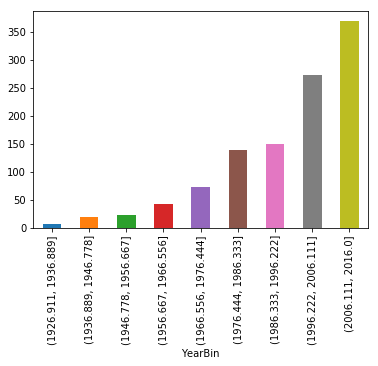

In [54]:
#By the below plot, we see that it makes sense to split the title_year into chunks of 10 years from 1927 to 2016
imdb_db['YearBin'] = pd.cut(imdb_db.title_year,bins=9) 
year_approx = imdb_db.groupby('YearBin')['make_profit'].sum()
year_approx.plot(kind='bar')

imdb_db.YearBin = LabelEncoder().fit_transform(imdb_db.YearBin)

imdb_db.drop('title_year', axis=1, inplace=True)

In [55]:
#All numerical values can be applied a Standard Scaler, for better and faster convex convergence
from sklearn.preprocessing import StandardScaler
scaler_ = StandardScaler()
for col in ['num_critic_for_reviews', 'duration','director_facebook_likes', 'actor_1_facebook_likes',
       'num_user_for_reviews', 'movie_facebook_likes', 'facenumber_in_poster']:
    imdb_db[col] = scaler_.fit_transform(imdb_db[col].values.reshape(-1,1))
imdb_db.describe()

imdb_db.to_csv('processed_imdb.csv')

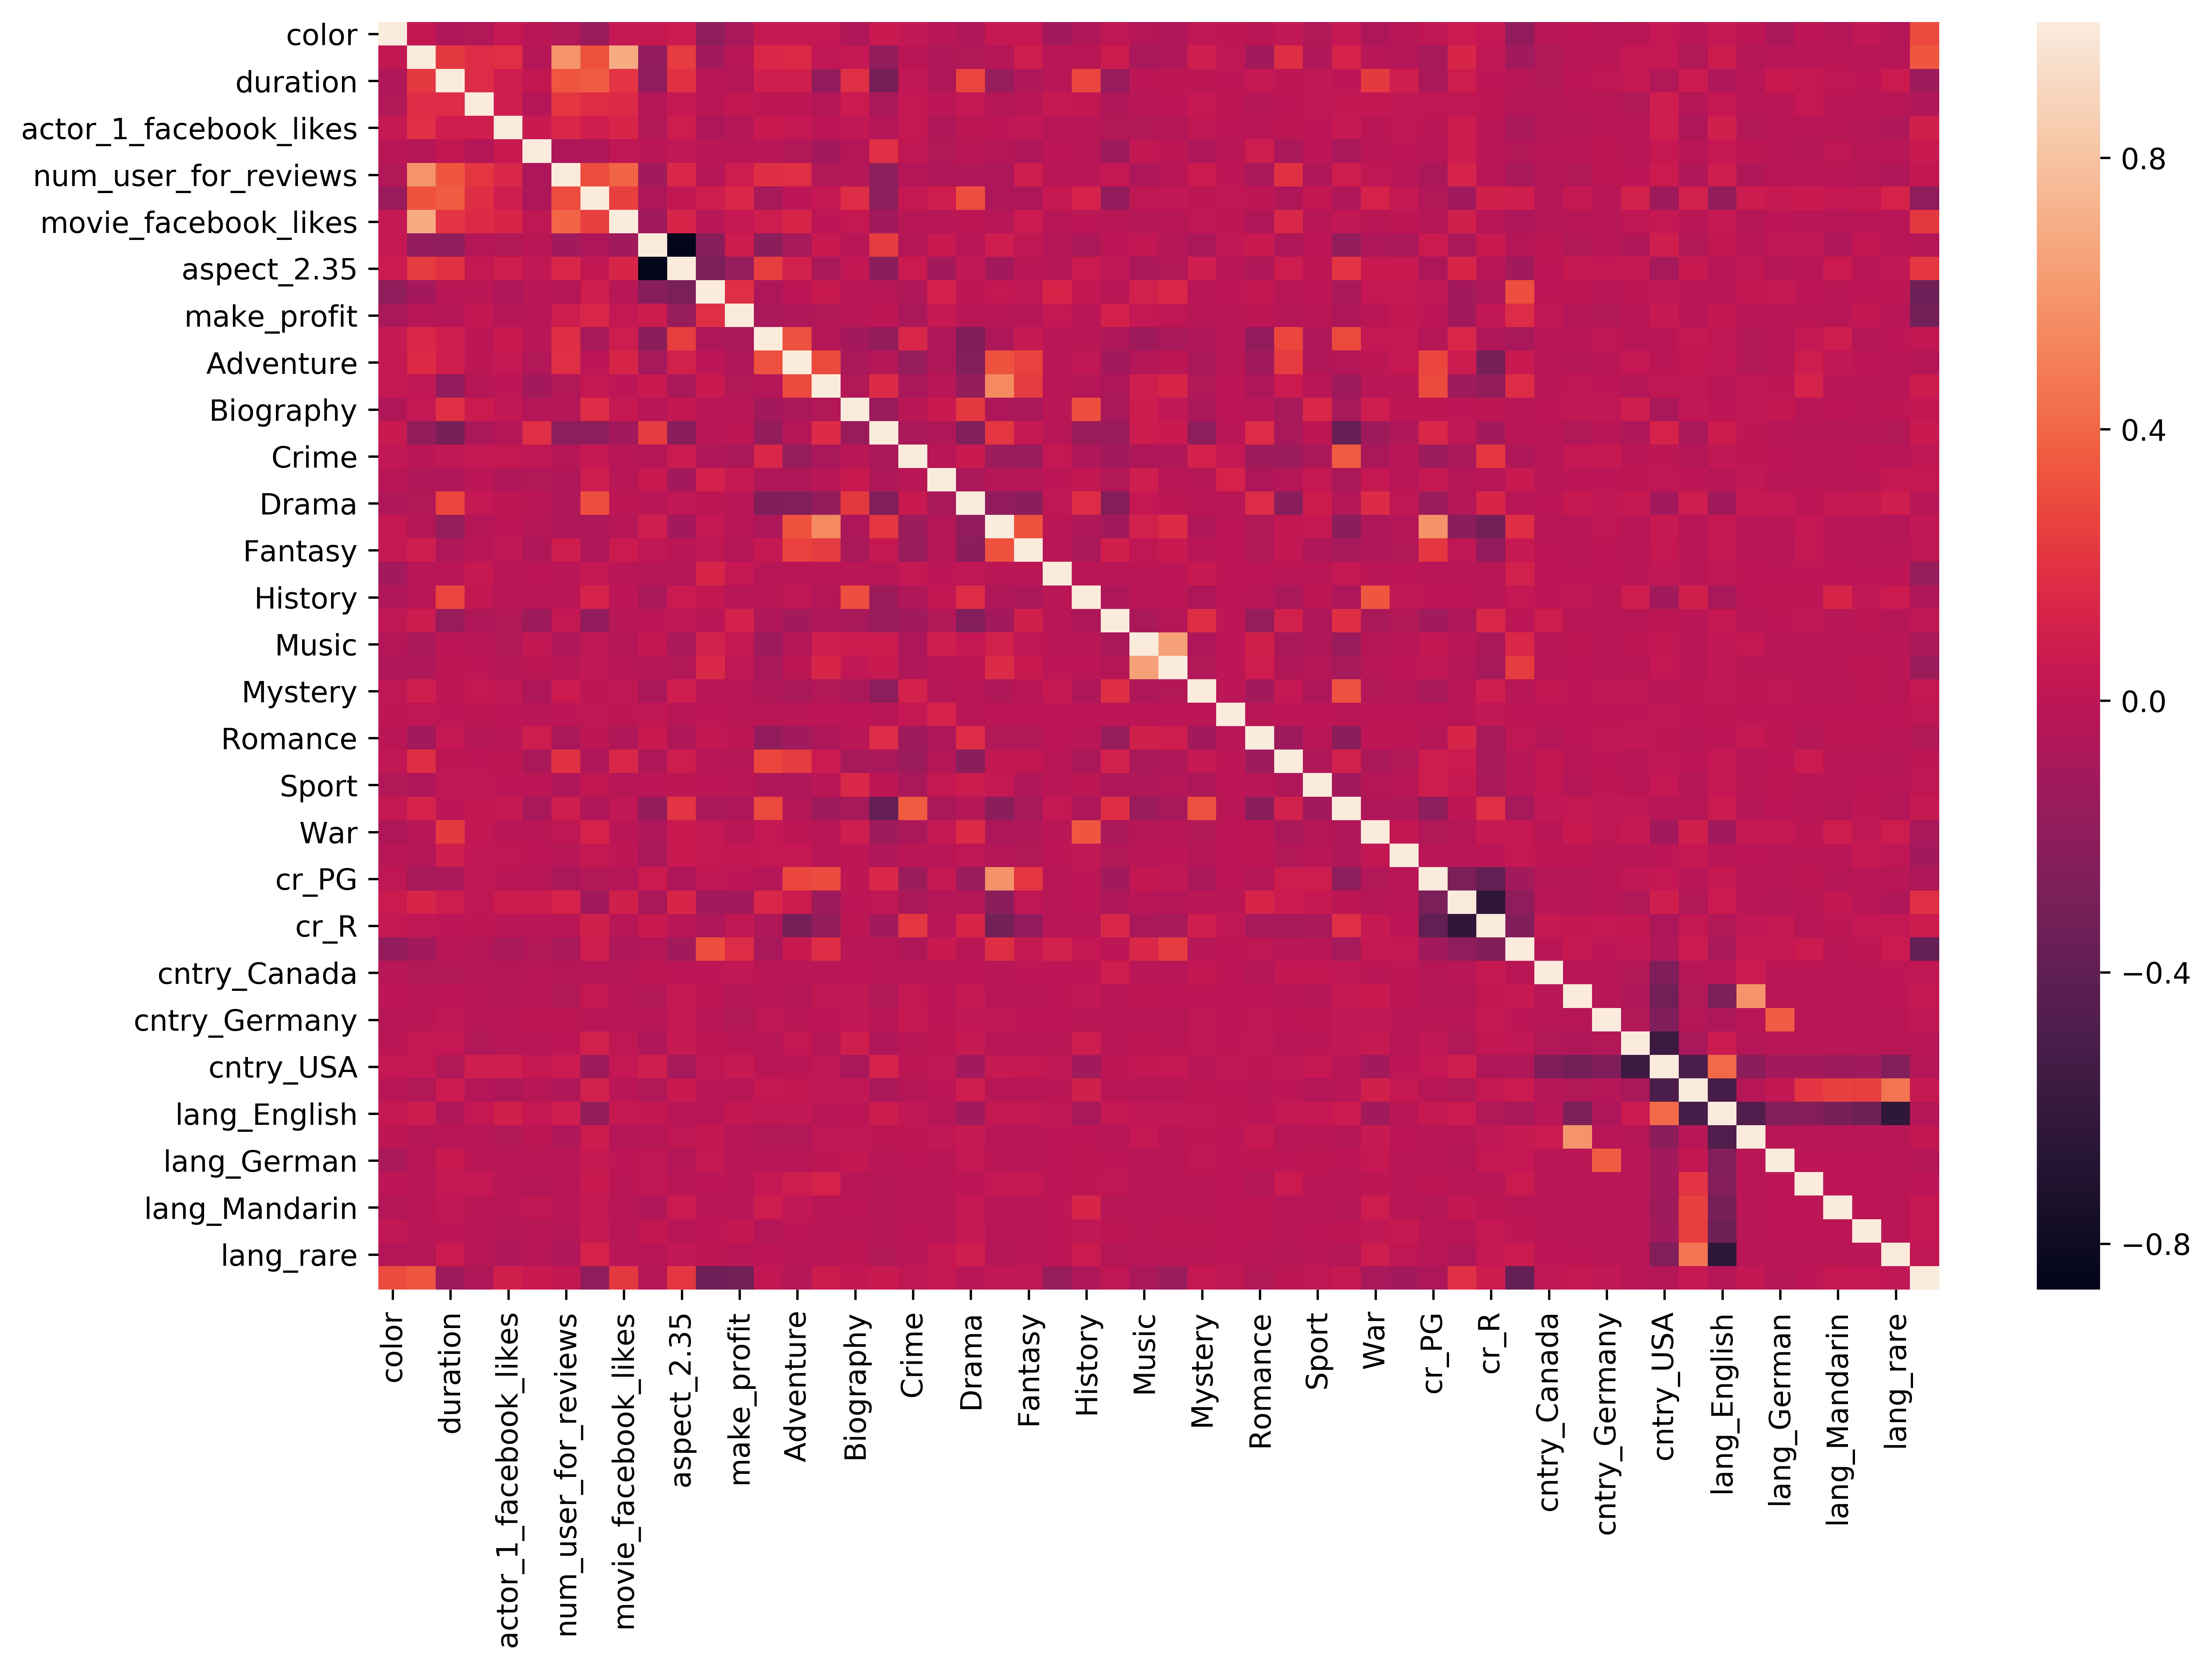

In [56]:
plt.figure(figsize=(12,8), dpi=600)
sb.heatmap(imdb_db.corr())

In [57]:
#**************** We have now converted our data to usable format ******
print('Pre-processing done !!')

Pre-processing done !!


In [58]:
# class_rating_ = {0:,1:,2:,3:,4:}

In [59]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
X = imdb_db.drop(['imdb_score','class_rating'], axis=1)
y = imdb_db['class_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
X_train.shape, X_test.shape

((3596, 53), (899, 53))

In [61]:
#Suppress Warninings
import warnings
warnings.filterwarnings('ignore')

#Machine Learning Algorithm (MLA) Selection and Initialization
from sklearn import ensemble, linear_model, naive_bayes, svm, tree, discriminant_analysis, gaussian_process, neighbors
from sklearn import model_selection
from xgboost import XGBClassifier

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean','MLA Train Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame()

cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .7, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv  = cv_split, return_train_score=True, scoring='accuracy')
#     print(cv_results)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, y_train)
    row_index+=1
    MLA_predict[MLA_name] = alg.predict(X_test)
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

MLA Name  \
2   GradientBoostingClassifier   
10               XGBClassifier   
7                          SVC   
3       RandomForestClassifier   
8                    LinearSVC   
4         LogisticRegressionCV   
1         ExtraTreesClassifier   
6         KNeighborsClassifier   
9       DecisionTreeClassifier   
0           AdaBoostClassifier   
5                   GaussianNB   

                                       MLA Parameters MLA Test Accuracy Mean  \
2   {'criterion': 'friedman_mse', 'init': None, 'l...                0.52215   
10  {'base_score': 0.5, 'booster': 'gbtree', 'cols...               0.517146   
7   {'C': 1.0, 'cache_size': 200, 'class_weight': ...                0.49861   
3   {'bootstrap': True, 'class_weight': None, 'cri...               0.491566   
8   {'C': 1.0, 'class_weight': None, 'dual': True,...               0.483411   
4   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...               0.478035   
1   {'bootstrap': False, 'class_weight': None, 'cr...                0.46988   
6   {'algorithm': 'auto', 'leaf_size': 30, 'metric...               0.442632   
9   {'class_weight': None, 'criterion': 'gini', 'm...               0.429657   
0   {'algorithm': 'SAMME.R', 'base_estimator': Non...               0.355329   
5            {'priors': None, 'var_smoothing': 1e-09}              0.0693234   

   MLA Train Accuracy Mean MLA Test Accuracy 3*STD   MLA Time  
2                  0.78085               0.0311399    2.60006  
10                0.678268               0.0383245    3.63148  
7                 0.539293               0.0424584    2.43629  
3                 0.987763               0.0327846  0.0349085  
8                 0.512912               0.0523888   0.777333  
4                 0.497576               0.0523534    5.84159  
1                        1               0.0240464  0.0368924  
6                 0.610727               0.0335306  0.0073947  
9                        1               0.0232355  0.0235443  
0                 0.368296                0.050034   0.226195  
5                0.0773937               0.0135526  0.0061903

In [62]:
plt.close()

plt.figure(figsize=(12,8))
sb.barplot(x='MLA Test Accuracy Mean', y = 'MLA Name', data = MLA_compare, color = 'g')
plt.title('Machine Learning Algorithm Accuracy Score \n')
plt.xlabel('Accuracy Score (%)')
plt.ylabel('Algorithm')

Text(0,0.5,'Algorithm')

In [63]:
model_rf = MLA[3]
model_rf.feature_importances_

array([0.00488873, 0.10246497, 0.0935286 , 0.08265209, 0.09082616,
       0.04043496, 0.11248848, 0.07003259, 0.01141504, 0.01502591,
       0.00703173, 0.018424  , 0.01479225, 0.01418164, 0.00525619,
       0.00625295, 0.01630915, 0.01225657, 0.00400096, 0.02620889,
       0.00747778, 0.0117531 , 0.00037216, 0.00353727, 0.01290337,
       0.00790724, 0.00442883, 0.00934704, 0.        , 0.01416635,
       0.01082664, 0.00449163, 0.01667712, 0.00378426, 0.00251025,
       0.00857271, 0.01381402, 0.01347549, 0.00596868, 0.00294197,
       0.00421176, 0.00299425, 0.00847477, 0.01470778, 0.00585613,
       0.00770602, 0.00164412, 0.00036727, 0.00075679, 0.00078578,
       0.00119272, 0.00250769, 0.04536716])

In [64]:
#Grid Search
import time
#Code is written for experimental/developmental purposes and not production ready!

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]
grid_param = {
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter

start = time.perf_counter()        
best_search = model_selection.GridSearchCV(estimator = model_rf, param_grid = grid_param, cv = cv_split, scoring = 'accuracy')
best_search.fit(X_train, y_train)
run = time.perf_counter() - start

best_param = best_search.best_params_
print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(model_rf.__class__.__name__, best_param, run))
model_rf.set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 74.66 seconds.
Total optimization time was 1.24 minutes.
----------


In [65]:
#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = model_selection.cross_validate(model_rf, X_train, y_train, cv  = cv_split, return_train_score=True, scoring='accuracy')
print('Train score:' , cv_results['train_score'].mean())
print('Test score:' , cv_results['test_score'].mean())

Train score: 1.0
Test score: 0.5462465245597776


In [66]:
pred_compare = pd.DataFrame({'Original': y_test, 'Predicted': model_rf.predict(X_test)})
pred_compare.to_csv('pred_compare.csv')

In [67]:
from sklearn.feature_selection import RFE
#rank all features, i.e continue the elimination until the last one
rfe = RFE(model_rf, n_features_to_select=1)
rfe.fit(X_train,y_train)
 
print("Features sorted by their rank:")
feat_imp = sorted(zip(map(lambda x: round(x, 4), rfe.ranking_), X_train.columns))
print(feat_imp)

Features sorted by their rank:
[(1, 'num_user_for_reviews'), (2, 'num_critic_for_reviews'), (3, 'actor_1_facebook_likes'), (4, 'duration'), (5, 'director_facebook_likes'), (6, 'movie_facebook_likes'), (7, 'YearBin'), (8, 'facenumber_in_poster'), (9, 'Drama'), (10, 'cr_PG-13'), (11, 'aspect_2.35'), (12, 'Thriller'), (13, 'cntry_USA'), (14, 'make_profit'), (15, 'Comedy'), (16, 'cr_R'), (17, 'Action'), (18, 'Horror'), (19, 'aspect_1.85'), (20, 'Romance'), (21, 'Adventure'), (22, 'Crime'), (23, 'Fantasy'), (24, 'cr_PG'), (25, 'Sci-Fi'), (26, 'lang_English'), (27, 'cr_rare'), (28, 'Mystery'), (29, 'cntry_UK'), (30, 'Family'), (31, 'aspect_rare'), (32, 'Music'), (33, 'Biography'), (34, 'cntry_rare'), (35, 'Documentary'), (36, 'Animation'), (37, 'color'), (38, 'Sport'), (39, 'War'), (40, 'History'), (41, 'cntry_France'), (42, 'Musical'), (43, 'lang_rare'), (44, 'cntry_Canada'), (45, 'cntry_Germany'), (46, 'Western'), (47, 'lang_French'), (48, 'lang_Spanish'), (49, 'lang_Mandarin'), (50, 'lang

In [68]:
#Through Recursive feature elimination, we can judge which features actually contribute to making 
#better predictions, and also reduce the dimensionallity of our dataset if lesser number of features
#give a considerate amoount of accuracy.
for how_many in [5,10,15,20,25,30,40,50]:
    X = imdb_db[[y for x,y in feat_imp[:how_many]]]
    y = imdb_db['class_rating']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    model_rf.fit(X_train,y_train)
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(model_rf, X_train, y_train, cv  = cv_split, return_train_score=True, scoring='accuracy')
    print('Train score:' , cv_results['train_score'], ' : For {}'.format(how_many))
    print('Test score:' , cv_results['test_score'], ' : For {}'.format(how_many))
    print('Mean score:' , cv_results['test_score'].mean(), ' : For {} features.'.format(how_many))



Train score: [1. 1. 1. 1. 1.]  : For 5
Test score: [0.4476367  0.44022243 0.44022243 0.43095459 0.43095459]  : For 5
Mean score: 0.43799814643188134  : For 5 features.
Train score: [1. 1. 1. 1. 1.]  : For 10
Test score: [0.50695088 0.49304912 0.49582947 0.50324374 0.51807229]  : For 10
Mean score: 0.5034291010194625  : For 10 features.
Train score: [1. 1. 1. 1. 1.]  : For 15
Test score: [0.54587581 0.5115848  0.53104727 0.53104727 0.5347544 ]  : For 15
Mean score: 0.5308619091751622  : For 15 features.
Train score: [1. 1. 1. 1. 1.]  : For 20
Test score: [0.54494903 0.54309546 0.53382762 0.53846154 0.54309546]  : For 20
Mean score: 0.5406858202038924  : For 20 features.
Train score: [1. 1. 1. 1. 1.]  : For 25
Test score: [0.55050973 0.5347544  0.53660797 0.53197405 0.54309546]  : For 25
Mean score: 0.5393883225208527  : For 25 features.
Train score: [1. 1. 1. 1. 1.]  : For 30
Test score: [0.54402224 0.54402224 0.53104727 0.53938832 0.5523633 ]  : For 30
Mean score: 0.5421686746987951  :

In [69]:
#We observe that just selecting 20 features for our RandomForest Model is enough to provide good accuracy on 
#cross validated scores. We keep only 20 features.
best_features = [y for x,y in feat_imp[:20]]
np.array(best_features)

array(['num_user_for_reviews', 'num_critic_for_reviews',
       'actor_1_facebook_likes', 'duration', 'director_facebook_likes',
       'movie_facebook_likes', 'YearBin', 'facenumber_in_poster', 'Drama',
       'cr_PG-13', 'aspect_2.35', 'Thriller', 'cntry_USA', 'make_profit',
       'Comedy', 'cr_R', 'Action', 'Horror', 'aspect_1.85', 'Romance'],
      dtype='<U23')

In [70]:
#Suppress Warninings
import warnings
warnings.filterwarnings('ignore')

#Machine Learning Algorithm (MLA) Selection and Initialization
from sklearn import ensemble, linear_model, naive_bayes, svm, tree, discriminant_analysis, gaussian_process, neighbors
from sklearn import model_selection
from xgboost import XGBClassifier

X = imdb_db[best_features]
y = imdb_db['class_rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

MLA = [
    #Ensemble Methods
    ensemble.AdaBoostClassifier(),
    ensemble.ExtraTreesClassifier(),
    ensemble.GradientBoostingClassifier(),
    ensemble.RandomForestClassifier(),

    
    #GLM
    linear_model.LogisticRegressionCV(),
    
    #Navies Bayes
    naive_bayes.GaussianNB(),
    
    #Nearest Neighbor
    neighbors.KNeighborsClassifier(),
    
    #SVM
    svm.SVC(probability=True),
    svm.LinearSVC(),
    
    #Trees    
    tree.DecisionTreeClassifier(),
    
    #xgboost: http://xgboost.readthedocs.io/en/latest/model.html
    XGBClassifier()    
    ]



#split dataset in cross-validation with this splitter class: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.ShuffleSplit.html#sklearn.model_selection.ShuffleSplit
#note: this is an alternative to train_test_split
#create table to compare MLA metrics
MLA_columns = ['MLA Name', 'MLA Parameters', 'MLA Test Accuracy Mean','MLA Train Accuracy Mean', 'MLA Test Accuracy 3*STD' ,'MLA Time']
MLA_compare = pd.DataFrame(columns = MLA_columns)

#create table to compare MLA predictions
MLA_predict = pd.DataFrame()

cv_split = model_selection.ShuffleSplit(n_splits = 5, test_size = .3, train_size = .7, random_state = 0 ) 
# run model 10x with 60/30 split intentionally leaving out 10%

#index through MLA and save performance to table
row_index = 0
for alg in MLA:

    #set name and parameters
    MLA_name = alg.__class__.__name__
    MLA_compare.loc[row_index, 'MLA Name'] = MLA_name
    MLA_compare.loc[row_index, 'MLA Parameters'] = str(alg.get_params())
    
    #score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
    cv_results = model_selection.cross_validate(alg, X_train, y_train, cv  = cv_split, return_train_score=True, scoring='accuracy')
#     print(cv_results)
    MLA_compare.loc[row_index, 'MLA Time'] = cv_results['fit_time'].mean()
    MLA_compare.loc[row_index, 'MLA Train Accuracy Mean'] = cv_results['train_score'].mean()
    MLA_compare.loc[row_index, 'MLA Test Accuracy Mean'] = cv_results['test_score'].mean()   
    #if this is a non-bias random sample, then +/-3 standard deviations (std) from the mean, should statistically capture 99.7% of the subsets
    MLA_compare.loc[row_index, 'MLA Test Accuracy 3*STD'] = cv_results['test_score'].std()*3   #let's know the worst that can happen!

    #save MLA predictions - see section 6 for usage
    alg.fit(X_train, y_train)
    row_index+=1
    MLA_predict[MLA_name] = alg.predict(X_test)
    
#print and sort table: https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.sort_values.html
MLA_compare.sort_values(by = ['MLA Test Accuracy Mean'], ascending = False, inplace = True)
MLA_compare

MLA Name  \
2   GradientBoostingClassifier   
10               XGBClassifier   
7                          SVC   
8                    LinearSVC   
3       RandomForestClassifier   
1         ExtraTreesClassifier   
4         LogisticRegressionCV   
6         KNeighborsClassifier   
9       DecisionTreeClassifier   
0           AdaBoostClassifier   
5                   GaussianNB   

                                       MLA Parameters MLA Test Accuracy Mean  \
2   {'criterion': 'friedman_mse', 'init': None, 'l...               0.501695   
10  {'base_score': 0.5, 'booster': 'gbtree', 'cols...               0.500212   
7   {'C': 1.0, 'cache_size': 200, 'class_weight': ...               0.496822   
8   {'C': 1.0, 'class_weight': None, 'dual': True,...               0.470763   
3   {'bootstrap': True, 'class_weight': None, 'cri...               0.470551   
1   {'bootstrap': False, 'class_weight': None, 'cr...               0.464195   
4   {'Cs': 10, 'class_weight': None, 'cv': 'warn',...               0.461229   
6   {'algorithm': 'auto', 'leaf_size': 30, 'metric...               0.432627   
9   {'class_weight': None, 'criterion': 'gini', 'm...               0.420975   
0   {'algorithm': 'SAMME.R', 'base_estimator': Non...               0.376059   
5            {'priors': None, 'var_smoothing': 1e-09}               0.252331   

   MLA Train Accuracy Mean MLA Test Accuracy 3*STD    MLA Time  
2                 0.786467               0.0402788     1.50818  
10                0.679201               0.0370829     1.56873  
7                 0.570754               0.0315884     1.00172  
8                 0.498728               0.0321964    0.613561  
3                 0.987375               0.0411126   0.0309192  
1                        1               0.0365894   0.0273266  
4                 0.474659               0.0357631     2.63097  
6                 0.616076               0.0294438  0.00418239  
9                        1               0.0480115   0.0147614  
0                  0.38347               0.0593863    0.184103  
5                 0.277475               0.0483803  0.00439434

In [71]:
model_rf = MLA[3]

In [72]:
#Grid Search
import time
#Code is written for experimental/developmental purposes and not production ready!

#Hyperparameter Tune with GridSearchCV: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
grid_n_estimator = [10, 50, 100, 300]
grid_ratio = [.1, .25, .5, .75, 1.0]
grid_learn = [.01, .03, .05, .1, .25]
grid_max_depth = [2, 4, 6, 8, 10, None]
grid_min_samples = [5, 10, .03, .05, .10]
grid_criterion = ['gini', 'entropy']
grid_bool = [True, False]
grid_seed = [0]
grid_param = {
            #RandomForestClassifier - http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html#sklearn.ensemble.RandomForestClassifier
            'n_estimators': grid_n_estimator, #default=10
            'criterion': grid_criterion, #default=”gini”
            'max_depth': grid_max_depth, #default=None
            'oob_score': [True], #default=False -- 12/31/17 set to reduce runtime -- The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': 6, 'n_estimators': 100, 'oob_score': True, 'random_state': 0} with a runtime of 146.35 seconds.
            'random_state': grid_seed
             }

start_total = time.perf_counter() #https://docs.python.org/3/library/time.html#time.perf_counter

start = time.perf_counter()        
best_search = model_selection.GridSearchCV(estimator = model_rf, param_grid = grid_param, cv = cv_split, scoring = 'accuracy')
best_search.fit(X_train, y_train)
run = time.perf_counter() - start

best_param = best_search.best_params_
print('The best parameter for {} is {} with a runtime of {:.2f} seconds.'.format(model_rf.__class__.__name__, best_param, run))
model_rf.set_params(**best_param) 


run_total = time.perf_counter() - start_total
print('Total optimization time was {:.2f} minutes.'.format(run_total/60))

print('-'*10)

The best parameter for RandomForestClassifier is {'criterion': 'entropy', 'max_depth': None, 'n_estimators': 300, 'oob_score': True, 'random_state': 0} with a runtime of 72.84 seconds.
Total optimization time was 1.21 minutes.
----------


In [73]:
#score model with cross validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html#sklearn.model_selection.cross_validate
cv_results = model_selection.cross_validate(model_rf, X_train, y_train, cv  = cv_split, return_train_score=True, scoring='accuracy')
print('Train score:' , cv_results['train_score'].mean())
print('Test score:' , cv_results['test_score'].mean())

Train score: 1.0
Test score: 0.5250000000000001


In [74]:
# plt.figure(figsize=(12,8))
# for x in imdb_db.columns:
#     if imdb_db[x].dtype not in [object]:
#         sb.boxplot(imdb_db[x])
#         plt.savefig(x+'_boxplot.png')
#         plt.close()

In [75]:
imdb_db['score_predict'] = model_rf.predict(imdb_db.drop(['imdb_score','class_rating'], axis=1)[best_features])

In [76]:
imdb_score_predict = [float(x) for x in imdb_db['score_predict']]
imdb_score_predict = np.array(imdb_score_predict)

In [77]:
imdb_score_true = [float(x) for x in imdb_db['imdb_score']]
imdb_score_true = np.array(imdb_score_true)

In [78]:
# [(x-y) for x,y in zip(imdb_score_true,imdb_score_predict)]

In [79]:
from sklearn.metrics import r2_score,log_loss, accuracy_score, mean_squared_error, mean_squared_log_error, adjusted_rand_score

In [80]:
mean_squared_log_error(imdb_score_true, imdb_score_predict), mean_squared_error(imdb_score_true, imdb_score_predict)

(0.008268276183748098, 0.33747719688542827)

In [81]:
r2_score(imdb_score_true, imdb_score_predict)

0.7094172154738154

In [82]:
imdb_db[['imdb_score', 'score_predict']].to_csv('finalimdbscore.csv')

In [86]:
plt.title('Point point plot between actual and expected ratings')
plt.xlabel('IMDB True Score')
plt.ylabel('IMDB Predicted Score')
sb.regplot(imdb_score_true, imdb_score_predict)


In [ ]:
#Conclusion, our model performs with an r2 score of 0.71 and a log loss of 0.008268276183748098
#The model serves as a good fit to solve the problem at hand.
#Since its a random forest model (bagging), it is very easy to deploy and the predictions can be much faster
#over boosting sequence models.